## Spell Checker using Language Models

### Imports and Initializations

Let's Import packages like os, re(for regex), maplotlib etc.
Initialize dictionaries for character probability and word probability using n-gram.

In [32]:
import sys, re, os ,pprint
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

pp = pprint.PrettyPrinter(indent=2)

caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

unigrams_char_probs = dict()
bigrams_char_probs = dict()
trigrams_char_probs = dict()

unigrams_word_probs = dict()
bigrams_word_probs = dict()
trigrams_word_probs = dict()


def split_into_sentences(text):
    """ To split text into list of sentences"""
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = text.replace("\r","")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + caps + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(caps + "[.]" + caps + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + caps + "[.]"," \\1<prd>",text)
    # if '”' in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

def get_words(sentences):
    """ Get words from all sentences into a list"""
    words = []
    for i in sentences:
        alpha="()[]{},*:;.?!_"
        sent=i
        for ch in alpha:
            sent=sent.replace(ch," ")
        w=sent.split(" ")
        for j in w:
            words.append(j.lower())
    return words


def get_word_freq(corpus):
    """ Make a dictionary and store words with their respective frequencies. """
    tokens={}
    for i in corpus:
        if i not in tokens:
            tokens[i]=0
        tokens[i]+=1
    return tokens

def get_character_freq(corpus):
    """ Make a dictionary and store characters with their respective frequencies. """
    char_dict=dict()
    for i in corpus:
        for ch in i:
            if char_dict.get(ch) == None:
                char_dict[ch] = 1
            else:
                char_dict[ch] += 1
    return char_dict

def graph_axis(n,a): 
    """ To plot graph"""
    c1=0
    y=[]
    for key in a:
        y.append(key[1])
        c1+=1
        if c1 == n:
            break
    x=range(len(y))
    return x,y



#Language Model and Smoothing


## Language Modelling

After tokenizing we are going to make some lists, dictionaries to store tokens using n-grams which will help us in grammar check , spell check.

In [25]:
def language_model(words,n,c):
    """ Return n-gram(list) of characters or words as specified."""
    if c == 'words':
        n_gram_w=list()
        for i in range(0,len(words)-n+1):
            temp=list()
            for j in range(0,n):
                temp.append(words[j+i])
            n_gram_w.append(temp)
        return n_gram_w
    
    elif c == 'characters':
        txt=''
        n_gram_c = list()
        for i in range(0,len(words)):
            txt = txt + words[i] +" "
        for i in range(0,len(txt)-n+1):
            c2=0
            temp = list()
            for j in range(0,n):
                if txt[i+j] == " ":
                    c2=1
                    break
                temp.append(txt[i+j])
            if c2 == 1:
                temp = list()
            else:
                n_gram_c.append(temp)
                c2=0
        return n_gram_c

def count_ngrams(ngram):
    """ Make a dictionary of any n-gram, value being it's frequency"""
    a=dict()
    for i in ngram:
        key =''
        for j in range(0,len(i)):
            key = key + i[j] + '~'
            c=key
        key = key[0:len(c)-1]
#         print(key)
        if a.get(key) == None:
            a[key] = 1
        else:
            a[key] += 1
    return a
    
def complete_ngram(word):
    """ To predict next character, given some characters using probability function."""
    for i in char_freq:
        new_word = word + i
        pp.pprint(new_word)
        pp.pprint(P(new_word))


def prob_l0(word, x):
    """ To predict probability of n-gram (words or characters)."""
    lengthc = 0
    lengthw = 0
    for key, value in char_freq.items():
        lengthc = lengthc + value
    for key, value in word_freq.items():
        lengthw = lengthw + value
        
    words = word.split("~")
#     print(words)
    if len(words) == 2:
        if x == 'characters':
            if bigrams_char_probs.get(word) == None:
                bigrams_char_probs[word] = float(bigrams_char_count[word])/char_freq[words[0]]
        elif x == 'words':
            if bigrams_word_probs.get(word) == None:
                bigrams_word_probs[word] = float(bigrams_word_count[word])/word_freq[words[0]]
    
    if len(words) == 3:
        if x == 'characters':
            if trigrams_char_probs.get(word) == None:
                trigrams_char_probs[word] = float(trigrams_char_count[word])/bigrams_char_count[words[0]+'~'+words[1]]
        elif x == 'words':
            if trigrams_word_probs.get(word) == None:
                trigrams_word_probs[word] = float(trigrams_word_count[word])/bigrams_word_count[words[0]+'~'+words[1]]
    
    if len(word) == 1:
        if x == 'characters':
            if unigrams_char_probs.get(word) == None:
                unigrams_char_probs[word] = float(char_freq[word])/lengthc
        elif x == 'words':
            if unigrams_word_probs.get(word) == None:
                unigrams_word_probs[word] = float(word_freq[word])/lengthw
    

def laplace_smoothing_val(b): 
    """ Laplace smoothing implemented for characters, b is the no of possible n-grams."""
    ls_unigrams_probs = dict()
    ls_bigrams_probs = dict()
    ls_trigrams_probs = dict()
    length = 0
    for key, value in char_freq.items():
        length = length + value
        
    for key, value in char_freq.items():
        if ls_unigrams_probs.get(key) == None:
            ls_unigrams_probs[key] = float(char_freq[key]+1)/(length+b)

    for i in range(len(bigrams_char)):
        temp = bigrams_char[i][0] + '~' + bigrams_char[i][1]
        if ls_bigrams_probs.get(temp) == None:
            ls_bigrams_probs[temp] = float((bigrams_char_probs[temp]+1))/(char_freq[bigrams_char[i][0]]+b)

    for i in range(len(trigrams_char)):
        temp = trigrams_char[i][0] + '~' + trigrams_char[i][1] + '~' + trigrams_char[i][2]
        if ls_trigrams_probs.get(temp) == None:
            ls_trigrams_probs[temp] = float((trigrams_char_probs[temp]+1))/(bigrams_char_probs[trigrams_char[i][1]+'~'+trigrams_char[i][2]]+b)

    return ls_unigrams_probs, ls_bigrams_probs, ls_trigrams_probs


def witten_bell(word): 
    """ Witten Bell is implemented here for bigram of characters."""
    count = 0
    length = 0
    data = word.split('~')
    word2 = data[1]
    for key, value in char_freq.items():
        length = length + value
    for key in bigrams_char_probs.keys():
        k_spl = key.split("~")
        if k_spl[1] == word2:
            count += 1
    onelambda = count / (count + length -1)
    lamb = 1 - onelambda  
    return ((lamb*bigrams_char_probs[word]) + (onelambda)*unigrams_char_probs[word2])

def get_score_backoff(self, group, n, factor=0.4, log=True):
        grams = self.get_ngrams(group, n)
        probs = []
        for gram in grams:
            probs.append(self.S(gram))
        if log:
            return np.log(probs).sum()
        return np.array(probs).prod()
  

In [66]:
complete_ngram("word")

'worde'
0.008220029354878255
'wordn'
0.0
'wordg'
0.0
'wordl'
0.001767748248360915
'wordi'
0.005038082507828608
'words'
0.007424542643115843
'wordh'
0.0
'wordm'
0.0
'wordo'
0.0008838741241804575
'wordf'
0.0
'wordt'
0.0
'wordr'
0.0
'wordd'
0.0
'wordb'
0.0
'wordy'
8.838741241804575e-05
'wordj'
0.0
'wordu'
8.838741241804575e-05
'worda'
0.0009722615365985032
'wordp'
0.0
"word'"
0.0001767748248360915
'wordx'
0.0
'wordc'
0.0
'word1'
0.0
'word8'
0.0
'word7'
0.0
'word9'
0.0
'wordv'
0.0
'word-'
8.838741241804575e-05
'wordw'
0.0
'word2'
0.0
'word6'
0.0
'word4'
0.0
'word0'
0.0
'word3'
0.0
'word5'
0.0
'wordk'
0.0
'word"'
0.0
'wordq'
0.0
'wordê'
0.0
'wordz'
0.0
'word&'
0.0
'wordï'
0.0
'word£'
0.0
'wordæ'
0.0
'wordà'
0.0
'wordû'
0.0
'wordé'
0.0
'wordö'
0.0
'word§'
0.0
'wordç'
0.0
'wordä'
0.0
'word>'
0.0
'word='
0.0
'wordü'
0.0
'wordâ'
0.0
'word+'
0.0


## Tokenizing Gutenberg Data



In [27]:
files = os.listdir('./Gutenberg/txt')
files = files[:1]
textf=[]
for file in files:
    f = open('./Gutenberg/txt/'+file, 'r')
    textf.append(f.read())
    f.close()
text=''
for i in textf:
    text = text + i + " "

sentences=split_into_sentences(text)
words=get_words(sentences)
words=list(filter(None,words))



word_freq = get_word_freq(words)
sorted_word_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse=True)
char_freq = get_character_freq(words)

unigrams_char = language_model(words, 1, "characters" )
unigrams_char_count = count_ngrams(unigrams_char)
unigrams_word = language_model(words, 1, "words")
unigrams_word_count = count_ngrams(unigrams_word)

# print(unigrams_word_count)
# bigrams = language_model(words,2)


## Zipf's Law

Time to verify Zipf's law by plotting frequency of 1000 words.

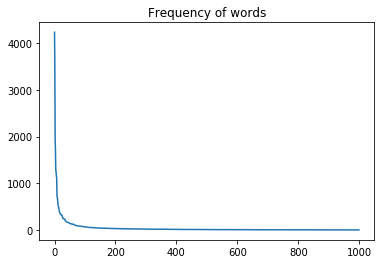

[ ('the', 4231),
  ('of', 3422),
  ('and', 1948),
  ('to', 1712),
  ('a', 1293),
  ('in', 1253),
  ('that', 1157),
  ('is', 1129),
  ('which', 724),
  ('it', 718),
  ('as', 649),
  ('be', 596),
  ('are', 516),
  ('or', 499),
  ('by', 485),
  ('with', 439),
  ('but', 396),
  ('not', 381),
  ('we', 357),
  ('for', 352),
  ('have', 340),
  ('from', 338),
  ('i', 337),
  ('his', 319),
  ('he', 319),
  ('this', 308),
  ('an', 287),
  ('they', 254),
  ('any', 251),
  ('on', 250),
  ('all', 248),
  ('may', 243),
  ('one', 234),
  ('if', 234),
  ('no', 232),
  ('hume', 213),
  ('their', 194),
  ('so', 192),
  ('has', 187),
  ('our', 185),
  ('other', 180),
  ('at', 175),
  ('--', 173),
  ('more', 172),
  ('can', 170),
  ('was', 165),
  ('its', 162),
  ('such', 156),
  ('will', 154),
  ('than', 148),
  ('what', 145),
  ('same', 144),
  ('would', 144),
  ('these', 142),
  ('there', 140),
  ('been', 134),
  ('who', 133),
  ('must', 132),
  ('my', 130),
  ('mind', 129),
  ('nature', 129),
  ('only

In [34]:
x, y = graph_axis(1000,sorted_word_freq)
plt.plot(x, y)
plt.title('Frequency of words')
plt.show()
pp.pprint(sorted_word_freq[:100])

## Probability of some n-grams

Now we are calculating probability of unigram, bigram, trigram (characters)

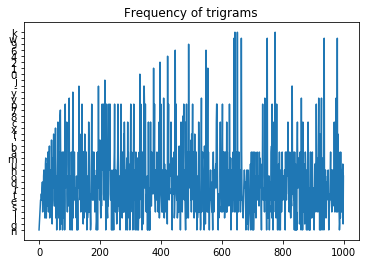

TypeError: unhashable type: 'slice'

In [62]:
#   TRIGRAMS OF CHARACTERS

trigrams_char = language_model(words, 3, "characters")
trigrams_char_count = count_ngrams(trigrams_char)
trigrams_sort_count = sorted(trigrams_char_count.items(), key = lambda x: x[1], reverse=True)

bigrams_char = language_model(words, 2, "characters")
bigrams_char_count = count_ngrams(bigrams_char)
bigrams_sort_count = sorted(bigrams_char_count.items(), key = lambda x: x[1], reverse=True)

for i in char_freq:
    prob_l0(i,"characters")
    
for key, value in bigrams_char_count.items():
    prob_l0(key, "characters")
    
for key, value in trigrams_char_count.items():
    prob_l0(key, "characters")

x, y = graph_axis(1000,trigrams_char)
plt.plot(x, y)
plt.title('Frequency of trigrams')
plt.show()
pp.pprint(trigrams_char_count[0:100])
y2 = np.log(np.log(y))
plt.plot(x, y2)
plt.title('log-log frequency of 3-grams')
plt.show()


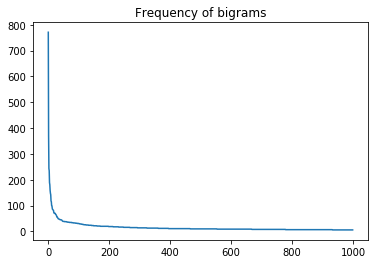

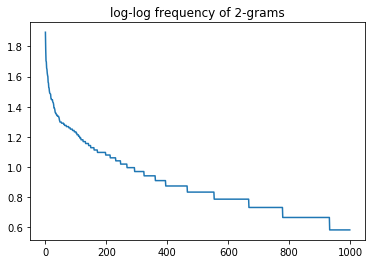

[ ('of~the', 771),
  ('in~the', 371),
  ('to~the', 244),
  ('it~is', 235),
  ('that~the', 189),
  ('to~be', 181),
  ('and~the', 159),
  ('of~a', 148),
  ('the~same', 142),
  ('from~the', 118),
  ('with~the', 115),
  ('by~the', 100),
  ('on~the', 99),
  ('may~be', 90),
  ('they~are', 85),
  ('is~the', 84),
  ('the~mind', 83),
  ('is~a', 82),
  ('of~his', 74),
  ('in~a', 71),
  ('for~the', 71),
  ('is~not', 70),
  ('the~other', 70),
  ('which~is', 70),
  ('there~is', 66),
  ('that~it', 65),
  ('as~the', 64),
  ('and~that', 61),
  ('all~the', 56),
  ('idea~of', 56),
  ('the~first', 55),
  ('which~we', 53),
  ('have~been', 50),
  ('of~this', 49),
  ('of~that', 49),
  ('of~which', 48),
  ('of~nature', 47),
  ('i~have', 47),
  ('in~which', 46),
  ('--~iv', 46),
  ('that~he', 45),
  ('as~a', 45),
  ('must~be', 45),
  ('of~our', 45),
  ('to~have', 44),
  ('into~the', 43),
  ('the~one', 41),
  ('and~in', 40),
  ('in~this', 39),
  ('and~to', 39),
  ('has~been', 39),
  ('which~are', 39),
  ('the~

In [36]:
# BIGRAMS OF WORDS
bigrams_word = language_model(words,2,"words")
bigrams_word_count = count_ngrams(bigrams_word)
bigrams_count = sorted(bigrams_word_count.items(), key = lambda x: x[1], reverse=True)

x, y = graph_axis(1000,bigrams_count)
y2 = np.log(np.log(y))
plt.plot(x, y)
plt.title('Frequency of bigrams')
plt.show()

plt.plot(x, y2)
plt.title('log-log frequency of 2-grams')
plt.show()
pp.pprint(bigrams_count[0:100])

## Example of Witten Bell and Laplace's equation

In [43]:
ls_unigrams_char_probs, ls_bigrams_char_probs, ls_trigrams_char_probs = laplace_smoothing_val(1000)

wb_bigrams_char_probs = dict()
for key, value in bigrams_char_count.items():
    if wb_bigrams_char_probs.get(key) == None:
        wb_bigrams_char_probs[key] = witten_bell(key)
# print(wb_bigrams_char_probs)

{'e~n': 0.09838798538793543, 'n~g': 0.07863720708662233, 'g~l': 0.025884834380759454, 'l~i': 0.1270450781863735, 'i~s': 0.13654678086760702, 's~h': 0.024548743650919275, 'm~e': 0.27497550773897145, 'o~f': 0.1552509377064494, 'l~e': 0.17796022544432802, 'e~t': 0.020307045226602004, 't~t': 0.016552612208300916, 't~e': 0.09216465440916735, 'e~r': 0.12464561501613294, 'r~s': 0.04494474486224558, 'e~d': 0.05578576566414209, 'd~i': 0.10639581094798925, 'i~t': 0.1316844732058947, 'b~y': 0.11154593534031379, 'j~o': 0.10947071049582613, 'o~h': 0.0009705411684661136, 'h~n': 0.0012933765688478553, 'm~o': 0.12325804935194751, 'o~r': 0.11566941004856812, 'r~l': 0.010304095811541276, 'e~y': 0.00912023615925333, 'h~u': 0.029797530488727828, 'u~m': 0.07679947443822152, 'i~l': 0.03626640825263546, 'l~l': 0.12128853839360192, 'l~u': 0.02406788672404864, 'u~s': 0.15670456572033414, 's~t': 0.1107507339637938, 't~r': 0.02588338448439977, 'r~a': 0.07512494494401534, 'a~t': 0.1726862257779187, 't~i': 0.10919

## Calculating trigrams_word_probs 

For grammatical test we'll calculate prob of trigrams of words.

In [59]:
trigrams_word = language_model(words, 3, "words")
trigrams_word_count = count_ngrams(trigrams_word)

for key, value in trigrams_word_count.items():
    if trigrams_word_probs.get(key) == None:
        prob_l0(key, "words")
# print(trigrams_word_probs)

{'english~men~of': 1.0, 'men~of~letters': 0.5, 'of~letters~edited': 0.2, 'letters~edited~by': 1.0, 'edited~by~john': 0.6666666666666666, 'by~john~morley': 0.6666666666666666, 'john~morley~hume': 0.25, 'morley~hume~illustration': 1.0, "hume~illustration~publisher's": 1.0, "illustration~publisher's~logo": 1.0, "publisher's~logo~hume": 1.0, 'logo~hume~by': 1.0, 'hume~by~professor': 1.0, 'by~professor~huxley': 0.3333333333333333, 'professor~huxley~london': 0.5, 'huxley~london~macmillan': 1.0, 'london~macmillan~and': 1.0, 'macmillan~and~co': 1.0, 'and~co~1879': 1.0, 'co~1879~the': 1.0, '1879~the~right': 1.0, 'the~right~of': 0.3333333333333333, 'right~of~translation': 1.0, 'of~translation~and': 1.0, 'translation~and~reproduction': 1.0, 'and~reproduction~is': 1.0, 'reproduction~is~reserved': 1.0, 'is~reserved~london': 1.0, 'reserved~london~r': 1.0, 'london~r~clay': 1.0, 'r~clay~sons': 1.0, 'clay~sons~and': 1.0, 'sons~and~taylor': 1.0, 'and~taylor~bread': 1.0, 'taylor~bread~street': 1.0, 'brea

## Spell Checker and Corrector

Spelling Corrector using Witten Bell Probability with depth level 2(edit level).
More depth can lead to more complexities.

In [65]:
def spell_checker(word): 
    "Most probable spelling correction for word."
    if word[0]==word[0].lower():
        return max(candidates(word), key=P)
    else:
        out= max(candidates(word), key=P)
        x=out[0]
        x=x.upper()
        out=x+out[1:]
        return out

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in unigrams_word_count)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def P(word):
    p = 1
    for i in range(0,len(word)-2):
        part_word = word[i] + '~' + word[i+1] + '~' + word[i+2]
        if trigrams_char_probs.get(part_word) == None:
            trigrams_char_probs[part_word] = 0
        p = p * trigrams_char_probs[part_word]
    return p



In [58]:
correct = spell_checker('directy')
pp.pprint(correct)

'direct'


## Grammaticality Test

We are using trigram_words_probs to calculate score for a sentence.
Can use wb_trigram_words_probs(Witten Bell Probability) to calculate better score.

In [56]:
test_sents = [['joseph', 'hume', 'died', 'when', 'david', 'was', 'an', 'infant'],
              ['when', 'david', 'was', 'an', 'infant', 'joseph', 'hume', 'died',]]

def score_grammaticality(sentence, n):
    p = 0
    for i in range(0,len(sentence)-2):
        part_word = sentence[i] + '~' + sentence[i+1] + '~' + sentence[i+2]
        if trigrams_word_probs.get(part_word) is None:
            trigrams_word_probs[part_word] = 0
        p = p + trigrams_word_probs[part_word]
    return p*100
temp = -10000000
for i in test_sents:
    p = score_grammaticality(i, 3)
    pp.pprint(p)
    pp.pprint(i)
    if p > temp:
        temp = p


    
    

433.3333333333333
['joseph', 'hume', 'died', 'when', 'david', 'was', 'an', 'infant']
283.33333333333337
['when', 'david', 'was', 'an', 'infant', 'joseph', 'hume', 'died']
